Copyright (c) 2023 Graphcore Ltd. All rights reserved.

# Training a GNN to do Fraud Detection on Graphcore IPUs using your own dataset with PyTorch Geometric

TODO: Everything in this section

TODO: Update links:

[![Run on Gradient](../../gradient-badge.svg)](https://console.paperspace.com/github/<runtime-repo>?machine=Free-IPU-POD4&container=<dockerhub-image>&file=<path-to-file-in-repo>)  [![Join our Slack Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)

>
> We aim to have our notebook app demos to be focused on what the user is trying to
> do. To help you do this correctly please read [our user personnas](https://graphcore.atlassian.net/wiki/spaces/PM/pages/3157131517/Notebook+personas#Ellie%3A-The-Data-Scientist%2C-Business-Analysis%2C-Consultant),
and when in doubt ask yourself "does that person care about this?".
> To support that the first paragraph will contain all the key information, to
> help users rapidly identify if this is the right notebook for them to go
> though, based on:
>
> - The task/business problem they are trying to solve,
> - The features that are used (Focus on big picture Deep learning features - e.g.
>  Distributed training, not I/O overlap).
>
> To achieve this, each notebook should start with the following 3 paragraphs
> (detailed in the next three comments):
>
> - a table highlighting what we are going to do
> - a very short intro (3-5 sentences)
> - clear "steps to resolution" (bullet points stating what the user will have
>    to do to tackle their problem on the IPU - these need to reflect the notebook,
>    and be as simple as possible)
> - links to additional related resources.
>

|  Domain | Tasks | Model | Datasets | Workflow |   Number of IPUs   | Execution time |
|---------|-------|-------|----------|----------|--------------|--------------|
|   GNNs   |  Fraud detection  | ? | ? | Training, evaluation | recommended: 16XX (min: 4X) | 20Xmn (X1h20mn)   |

>
>
> Start with a short introduction to the notebook. [suggested 3-5 sentences]
>
> This intro should focus on the problem you are fixing, and not on any IPU specific
> or framework specific features. The mindset is that anything that is non-standard
> is a barrier to entry, and will risk the user giving up.
>
> This short introduction should be followed by a clear bullet point summary of
> the steps of the demo. Each outcome should be of the form:
> - what the user will do (active verb) [and (optionally) how they do
>   it]. Jargon, if any, goes to the end of the bullet point.

In this demo, you will learn how to:

- Turn tabular transaction data into a PyTorch Geometric dataset
- Select a model suitable for the task of predicting fraudulent transactions
- Train the model on Graphcore IPUs
- Run validation on the trained model

This notebook assumes some familiarity with PopTorch as well as PyTorch Geometric (PyG). For additional resources please consult:
* [PopTorch Documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/index.html)
* [PopTorch Examples and Tutorials](https://docs.graphcore.ai/en/latest/examples.html#pytorch)
* [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)
* [PopTorch Geometric Documentation](https://docs.graphcore.ai/projects/poptorch-geometric-user-guide/en/latest/index.html)

[![Join our Slack Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)

In [1]:
# Make imported python modules automatically reload when the files are changed
# needs to be before the first import.
%load_ext autoreload
%autoreload 2
# TODO: remove at the end of notebook development

## Environment setup

[![Run on Gradient](../../gradient-badge.svg)](TODO)

The best way to try this demo is on Paperspace Gradient's cloud IPUs. To use on other hardware
make sure that you have the Poplar SDK enabled with the latest PopTorch Geometric installed.

In [2]:
%pip install -q -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


To improve your experience we read some configuration related to the environment you are running the notebook in.

In [3]:
import os

number_of_ipus = int(os.getenv("NUM_AVAILABLE_IPU", 16))
pod_type = os.getenv("GRAPHCORE_POD_TYPE", "pod16")
executable_cache_dir = os.getenv("POPLAR_EXECUTABLE_CACHE_DIR", "/tmp/exe_cache/")

# TODO Remove default
dataset_directory = os.getenv("DATASETS_DIR", "~")
checkpoint_directory = os.getenv("CHECKPOINT_DIR")

## Loading tabular data into PyTorch Geometric

In [4]:
import torch

### Getting the dataset

TODO: Using https://www.kaggle.com/c/ieee-fraud-detection/data

TODO: Run a script to download and tidy data?

In [5]:
import os.path as osp
import pandas as pd

raw_dataset_path = osp.join(dataset_directory, "ieee-fraud-detection", "raw")

train_transaction_path = osp.join(raw_dataset_path, "train_transaction.csv")
train_identity_path = osp.join(raw_dataset_path, "train_identity.csv")
train_transaction_df = pd.read_csv(train_transaction_path)
train_identity_df = pd.read_csv(train_identity_path)

test_transaction_path = osp.join(raw_dataset_path, "test_transaction.csv")
test_identity_path = osp.join(raw_dataset_path, "test_identity.csv")
test_transaction_df = pd.read_csv(test_transaction_path)
test_identity_df = pd.read_csv(test_identity_path)

In [6]:
transaction_df = pd.concat([train_transaction_df, test_transaction_df], axis=0)
identity_df = pd.concat([train_identity_df, test_identity_df], axis=0)

In [7]:
transaction_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0.0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0.0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0.0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0.0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0.0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
identity_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# TODO: Remove this
transaction_df = transaction_df.head()
identity_df = identity_df.head()

In [10]:
transaction_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0.0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0.0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0.0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0.0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0.0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Sort by datetime, later we will use this to make a training and validation split
transaction_df.sort_values("TransactionDT")

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0.0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0.0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0.0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0.0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0.0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Inspecting the dataset

TODO: Look at a few of the columns - call out important ones we will use for features and labels

TODO: Create validation / test split

NOTES: TODO: Remove

- Nodes are transaction IDs
-

### Creating a PyTorch Geometric dataset

TODO: Create PyTorch Geometric dataset from above - maybe move to a separate script

In [12]:
get_cat_map = lambda vals: {val: idx for idx, val in enumerate(vals)}

In [13]:
def get_edge_list(transaction_df, to_key, cat_map):
    edge_list = torch.zeros((2, len(transaction_df)), dtype=torch.long)

    for idx, transaction in transaction_df.iterrows():
        edge_list[0][idx] = idx
        edge_list[1][idx] = cat_map[transaction[to_key]]
    
    return edge_list

In [14]:
# TODO: This takes ages
# TODO: Doesn't work if all data is used
# TODO: Tidy this -> make encoders


def get_nodes_and_edges(df, identifier):
    # Find number of unique categories for this node type
    unique_entries = df[identifier].drop_duplicates()
    # Create a map of category to value
    entry_map = get_cat_map(unique_entries)
    # Create node features from map
    node_features = torch.zeros((len(entry_map), len(unique_entries)), dtype=torch.float32)
    for val in entry_map.values():
        node_features[val][val] = 1.0
    # Create edge list mapping transaction to node type
    edges = get_edge_list(df, identifier, entry_map)
    return node_features, edges


In [15]:
product_code_node_feats, product_code_edges = get_nodes_and_edges(transaction_df, "ProductCD")
product_code_node_feats, product_code_edges

(tensor([[1., 0.],
         [0., 1.]]),
 tensor([[0, 1, 2, 3, 4],
         [0, 0, 0, 0, 1]]))

In [16]:
pur_email_domain_node_feats, pur_email_domain_edges = get_nodes_and_edges(transaction_df, "P_emaildomain")
pur_email_domain_node_feats, pur_email_domain_edges

(tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]),
 tensor([[0, 1, 2, 3, 4],
         [0, 1, 2, 3, 1]]))

In [17]:
rec_email_domain_node_feats, rec_email_domain_edges = get_nodes_and_edges(transaction_df, "R_emaildomain")
rec_email_domain_node_feats, rec_email_domain_edges

(tensor([[1.]]),
 tensor([[0, 1, 2, 3, 4],
         [0, 0, 0, 0, 0]]))

In [18]:
# TODO: Create node features

In [19]:
import torch

from torch_geometric.data import HeteroData

data = HeteroData()

In [20]:
# TODO: Update this with real features
data["transaction"].num_nodes = len(transaction_df)
data["transaction"].x = torch.arange(data["transaction"].num_nodes, dtype=torch.float32).unsqueeze(-1)
# TODO: Labels
data["transaction"].y = torch.tensor(transaction_df['isFraud'], dtype=int)

data["product_code"].x = product_code_node_feats
data["transaction", "to", "product_code"].edge_index = product_code_edges

data["purchaser_email_domain"].x = pur_email_domain_node_feats
data["transaction", "to", "purchaser_email_domain"].edge_index = pur_email_domain_edges

data["recipient_email_domain"].x = rec_email_domain_node_feats
data["transaction", "to", "recipient_email_domain"].edge_index = rec_email_domain_edges

/tmp/ipykernel_79554/2096791581.py:5: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data["transaction"].y = torch.tensor(transaction_df['isFraud'], dtype=int)


In [21]:
data

HeteroData(
  transaction={
    num_nodes=5,
    x=[5, 1],
    y=[5]
  },
  product_code={ x=[2, 2] },
  purchaser_email_domain={ x=[4, 4] },
  recipient_email_domain={ x=[1, 1] },
  (transaction, to, product_code)={ edge_index=[2, 5] },
  (transaction, to, purchaser_email_domain)={ edge_index=[2, 5] },
  (transaction, to, recipient_email_domain)={ edge_index=[2, 5] }
)

```python
data = HeteroData(
    transaction={
        x=[],
        y=[],
        train_mask=[],
        val_mask=[],
        test_mask=[]
    },
    card_info_1={},
    card_info_2={},
    card_info_3={},
    card_info_4={},
    card_info_5={},
    card_info_6={},
    product_code={},
    purchaser_billing_addr={},
    purchaser_billing_country={},
    purchaser_email_domain={},
    recipient_email_domain={}
    (transaction, to, card_info_1)={edge_index=[2, ]},
    (transaction, to, card_info_2)={edge_index=[2, ]},
    (transaction, to, card_info_3)={edge_index=[2, ]},
    (transaction, to, card_info_4)={edge_index=[2, ]},
    (transaction, to, card_info_5)={edge_index=[2, ]},
    (transaction, to, card_info_6)={edge_index=[2, ]},
    (transaction, to, product_code)={edge_index=[2, ]},
    (transaction, to, purchaser_billing_addr)={edge_index=[2, ]},
    (transaction, to, purchaser_billing_country)={edge_index=[2, ]},
    (transaction, to, purchaser_email_domain)={edge_index=[2, ]},
    (transaction, to, recipient_email_domain)={edge_index=[2, ]},
)
```

## Preprocess

In [22]:
import torch_geometric.transforms as T

data = T.ToUndirected()(data)
data = T.AddSelfLoops()(data)
data = T.NormalizeFeatures()(data)

data

HeteroData(
  transaction={
    num_nodes=5,
    x=[5, 1],
    y=[5]
  },
  product_code={ x=[2, 2] },
  purchaser_email_domain={ x=[4, 4] },
  recipient_email_domain={ x=[1, 1] },
  (transaction, to, product_code)={ edge_index=[2, 5] },
  (transaction, to, purchaser_email_domain)={ edge_index=[2, 5] },
  (transaction, to, recipient_email_domain)={ edge_index=[2, 5] },
  (product_code, rev_to, transaction)={ edge_index=[2, 5] },
  (purchaser_email_domain, rev_to, transaction)={ edge_index=[2, 5] },
  (recipient_email_domain, rev_to, transaction)={ edge_index=[2, 5] }
)

In [23]:
# TODO: Has self loops worked?

### Visualize

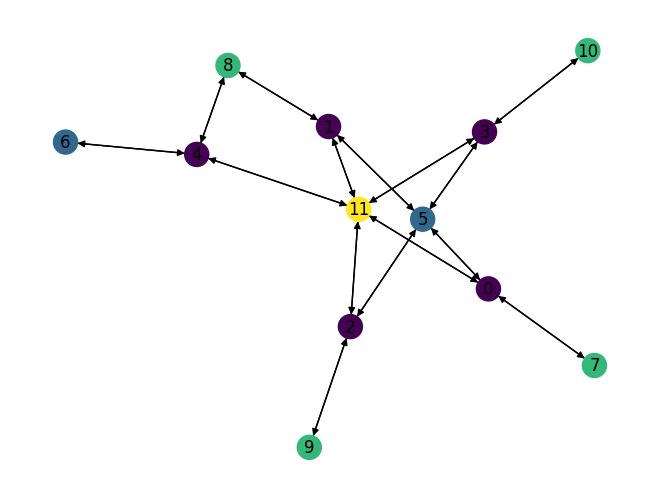

In [24]:
import networkx as nx
from matplotlib import pyplot as plt
from torch_geometric.utils import to_networkx

# Convert to homogeneous
data_homogeneous = data.to_homogeneous()
g = to_networkx(data_homogeneous)
# Use node types as colour map
colour_map = data_homogeneous.node_type

# TODO: This maybe?
## Get labels
#labels = {str(idx): val for idx, val in enumerate(data_homogeneous.y)}

# Plot the graph
nx.draw(g, node_color=colour_map, with_labels=True)
plt.show()

### Create dataset splits

TODO: We sort by time above and then select those from more recent as the validation and test

In [25]:
num_nodes_train = int(0.8 * data["transaction"].num_nodes)
data["transaction"].train_mask = torch.zeros(data["transaction"].num_nodes, dtype=bool)
data["transaction"].train_mask[:num_nodes_train] = True
data["transaction"].val_mask = torch.zeros(data["transaction"].num_nodes, dtype=bool)
data["transaction"].val_mask[num_nodes_train:] = True

print(f"Number of training nodes: {data['transaction'].train_mask.sum()}")
print(f"Number of validation nodes: {data['transaction'].val_mask.sum()}")

Number of training nodes: 4
Number of validation nodes: 1


## Dataloading

TODO: Is graph too large that need to do some sampling - neighbour sampling

In [59]:
from draft_fixed_size_neighbour_loader import FixedSizeNeighborLoader

batch_size = 2
num_layers = 2

train_loader_ipu = FixedSizeNeighborLoader(
    data,
    num_neighbors=[15] * num_layers,
    batch_size=batch_size,
    input_nodes=('transaction', data['transaction'].train_mask),
    collater_args={"num_nodes": 10,
                   "num_edges": 50,
                   "exclude_keys": ("batch_size",),
                   "add_masks_to_batch": True},
)

In [51]:
sample = next(iter(train_loader_ipu))

In [58]:
print(sample['transaction']['input_id'])
print(sample['transaction']['nodes_mask'])
print(sample['transaction']['batch'])
print(sample['graphs_mask'])

tensor([0., 1., 0., 0., 0., 0., 0.])
tensor([ True,  True,  True,  True,  True, False, False, False, False, False])
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
tensor([ True, False])


In [28]:
# TODO: Verify model with padded and unpadded

## Picking the right model

TODO: Describe the task

TODO: Describe different relations type - want something that can do different relations (heterogeneous graph) - RGCN could be a sensible choice
    - but requires weights for every relation type - we have 11 relation types so might be ok

TODO: Try CompGCN
    - Only requires 3 weights - in, out, self loops

In [33]:
from torch_geometric.nn import SAGEConv, to_hetero


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index, node_mask=None, target=None):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)

        if self.training:
            target = torch.where(node_mask, target, -100)
            loss = nn.functional.cross_entropy(x, target)
            return x, loss

        return x


model = GNN(hidden_channels=64, out_channels=2)
model = to_hetero(model, data.metadata(), aggr="sum")
model

GraphModule(
  (conv1): ModuleDict(
    (transaction__to__product_code): SAGEConv((-1, -1), 64, aggr=mean)
    (transaction__to__purchaser_email_domain): SAGEConv((-1, -1), 64, aggr=mean)
    (transaction__to__recipient_email_domain): SAGEConv((-1, -1), 64, aggr=mean)
    (product_code__rev_to__transaction): SAGEConv((-1, -1), 64, aggr=mean)
    (purchaser_email_domain__rev_to__transaction): SAGEConv((-1, -1), 64, aggr=mean)
    (recipient_email_domain__rev_to__transaction): SAGEConv((-1, -1), 64, aggr=mean)
  )
  (conv2): ModuleDict(
    (transaction__to__product_code): SAGEConv((-1, -1), 2, aggr=mean)
    (transaction__to__purchaser_email_domain): SAGEConv((-1, -1), 2, aggr=mean)
    (transaction__to__recipient_email_domain): SAGEConv((-1, -1), 2, aggr=mean)
    (product_code__rev_to__transaction): SAGEConv((-1, -1), 2, aggr=mean)
    (purchaser_email_domain__rev_to__transaction): SAGEConv((-1, -1), 2, aggr=mean)
    (recipient_email_domain__rev_to__transaction): SAGEConv((-1, -1), 2

In [85]:
from torch_geometric.nn import HeteroConv, SAGEConv, Linear


# TODO: Do I need to add reverse edges
# TODO: It is ugly not doing lazy initialization - check if lazy initialization works


class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, batch_size):
        super().__init__()
        self.batch_size = batch_size

        self.convs = torch.nn.ModuleList()
        self.convs.append(
            HeteroConv({
                ('transaction', 'to', 'product_code'): SAGEConv((1, 2), hidden_channels),
                ('transaction', 'to', 'purchaser_email_domain'): SAGEConv((1, 4), hidden_channels),
                ('transaction', 'to', 'recipient_email_domain'): SAGEConv((1, 1), hidden_channels),
                ('product_code', "rev_to", "transaction"): SAGEConv((2, 1), hidden_channels),
                ('purchaser_email_domain', "rev_to", "transaction"): SAGEConv((4, 1), hidden_channels),
                ('recipient_email_domain', "rev_to", "transaction"): SAGEConv((1, 1), hidden_channels),
            }, aggr='sum'))
        self.convs.append(
            HeteroConv({
                ('transaction', 'to', 'product_code'): SAGEConv(hidden_channels, hidden_channels),
                ('transaction', 'to', 'purchaser_email_domain'): SAGEConv(hidden_channels, hidden_channels),
                ('transaction', 'to', 'recipient_email_domain'): SAGEConv(hidden_channels, hidden_channels),
                ('product_code', "rev_to", "transaction"): SAGEConv(hidden_channels, hidden_channels),
                ('purchaser_email_domain', "rev_to", "transaction"): SAGEConv(hidden_channels, hidden_channels),
                ('recipient_email_domain', "rev_to", "transaction"): SAGEConv(hidden_channels, hidden_channels),
            }, aggr='sum'))

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict, target=None):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}
        out = self.lin(x_dict['transaction'])
        if self.training:
            loss = F.cross_entropy(out[:self.batch_size],
                                   target[:self.batch_size])
            return out, loss

        return out


model = HeteroGNN(hidden_channels=64,
                  out_channels=2,
                  num_layers=num_layers,
                  batch_size=batch_size)
model

HeteroGNN(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=6)
    (1): HeteroConv(num_relations=6)
  )
  (lin): Linear(64, 2, bias=True)
)

In [87]:
with torch.no_grad():  # Initialize lazy modules.
    out_cpu = model(data.x_dict,
                    data.edge_index_dict,
                    target=data["transaction"].y)

In [88]:
out_cpu

(tensor([[ 0.5536, -0.1145],
         [ 0.2672, -0.4001],
         [ 0.2380, -0.3742],
         [ 0.1779, -0.2423],
         [ 0.5195, -0.4146]]),
 tensor(0.4140))

In [89]:
model

HeteroGNN(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=6)
    (1): HeteroConv(num_relations=6)
  )
  (lin): Linear(64, 2, bias=True)
)

In [90]:
print(model.convs[0].convs["transaction__to__product_code"].lin_l)
print(model.convs[0].convs["transaction__to__product_code"].lin_r)
print(model.convs[1].convs["transaction__to__product_code"].lin_l)
print(model.convs[1].convs["transaction__to__product_code"].lin_r)
print(model.convs[0].convs["product_code__rev_to__transaction"].lin_l)
print(model.convs[0].convs["product_code__rev_to__transaction"].lin_r)

Linear(1, 64, bias=True)
Linear(2, 64, bias=False)
Linear(64, 64, bias=True)
Linear(64, 64, bias=False)
Linear(2, 64, bias=True)
Linear(1, 64, bias=False)


In [91]:
model.convs[0].convs["recipient_email_domain__rev_to__transaction"].aggr_module

MeanAggregation()

In [92]:
model.convs[0].convs

ModuleDict(
  (transaction__to__product_code): SAGEConv((1, 2), 64, aggr=mean)
  (transaction__to__purchaser_email_domain): SAGEConv((1, 4), 64, aggr=mean)
  (transaction__to__recipient_email_domain): SAGEConv((1, 1), 64, aggr=mean)
  (product_code__rev_to__transaction): SAGEConv((2, 1), 64, aggr=mean)
  (purchaser_email_domain__rev_to__transaction): SAGEConv((4, 1), 64, aggr=mean)
  (recipient_email_domain__rev_to__transaction): SAGEConv((1, 1), 64, aggr=mean)
)

In [93]:
out_cpu_grad = model(data.x_dict,
                     data.edge_index_dict,
                     target=data["transaction"].y)
out_cpu_grad

(tensor([[ 0.5536, -0.1145],
         [ 0.2672, -0.4001],
         [ 0.2380, -0.3742],
         [ 0.1779, -0.2423],
         [ 0.5195, -0.4146]], grad_fn=<AddmmBackward0>),
 tensor(0.4140, grad_fn=<NllLossBackward0>))

In [94]:
import poptorch

model.eval()
inf_model = poptorch.inferenceModel(model)
out_ipu = inf_model(data.x_dict,
                    data.edge_index_dict,
                    target=data["transaction"].y)
out_ipu

[17:04:19.808] [poptorch::python] [warning] Dicts as inputs only have partial support, they can be accessed using literal keys, but full Python functionality is not enabled. Consider changing dict inputs to tuple.
[17:04:19.809] [poptorch::python] [warning] Dicts as inputs only have partial support, they can be accessed using literal keys, but full Python functionality is not enabled. Consider changing dict inputs to tuple.
[17:04:19.828] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 1867
[17:04:19.828] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 1868
[17:04:19.828] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 1869
[17:04:19.828] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 1870
[17:04:19.829] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 1871
[17:04:19.829] [poptorch:cpp] [warning] [DISPATCHER] Type coer

Error: In unknown:0: 'popart_exception': Failure in ReshapeOp::setup() for Op(1/recipient_email_domain__rev_to__transaction/aggr_module/Reshape (ai.onnx.Reshape:5), inputs=[1/recipient_email_domain__rev_to__transaction/aggr_module/Max:0], outputs=[1/recipient_email_domain__rev_to__transaction/aggr_module/Reshape:0]). Trying to reshape from [5] to [2 1]. The number of elements of the input is 5, while the number of elements of the output is 2. The number of elements cannot change for a ReshapeOp
Error raised in:
  [0] popart::InferenceSession::createFromOnnxModel
  [1] Compiler::initSession
  [2] LowerToPopart::compile
  [3] compileWithManualTracing


In [ ]:
assert torch.allclose(out_cpu[0], out_ipu[0])

AssertionError: 

In [ ]:
# TODO: CompGCN?

## Training the model

TODO: Train the model in the normal way

In [95]:
learning_rate = 0.001
num_epochs = 1

In [96]:
import poptorch

model.train()
optimizer = poptorch.optim.Adam(model.parameters(), lr=learning_rate)
training_model = poptorch.trainingModel(model, optimizer=optimizer)

In [97]:
for epoch in range(num_epochs):
    _, loss = training_model(data.x_dict,
                             data.edge_index_dict,
                             target=data['transaction'].y)
    print(loss)

[17:04:34.024] [poptorch::python] [warning] Dicts as inputs only have partial support, they can be accessed using literal keys, but full Python functionality is not enabled. Consider changing dict inputs to tuple.
[17:04:34.025] [poptorch::python] [warning] Dicts as inputs only have partial support, they can be accessed using literal keys, but full Python functionality is not enabled. Consider changing dict inputs to tuple.
[17:04:34.045] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2311
[17:04:34.046] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2312
[17:04:34.046] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2313
[17:04:34.046] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2314
[17:04:34.046] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2315
[17:04:34.046] [poptorch:cpp] [warning] [DISPATCHER] Type coer

Error: In unknown:0: 'popart_exception': Failure in ReshapeOp::setup() for Op(1/recipient_email_domain__rev_to__transaction/aggr_module/Reshape (ai.onnx.Reshape:5), inputs=[1/recipient_email_domain__rev_to__transaction/aggr_module/Max:0], outputs=[1/recipient_email_domain__rev_to__transaction/aggr_module/Reshape:0]). Trying to reshape from [5] to [2 1]. The number of elements of the input is 5, while the number of elements of the output is 2. The number of elements cannot change for a ReshapeOp
Error raised in:
  [0] popart::TrainingSession::createFromOnnxModel
  [1] Compiler::initSession
  [2] LowerToPopart::compile
  [3] compileWithManualTracing
  [4] popart::Graph::constructFromOnnxGraph(onnx::GraphProto const&)
  [5] popart::Ir::constructFromOnnxGraph(onnx::GraphProto const&, popart::Scope const&)
  [6] popart::Ir::constructForwards()
  [7] popart::Ir::prepareImpl(popart::IrBundle const&, std::map<unsigned long, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::less<unsigned long>, std::allocator<std::pair<unsigned long const, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&, unsigned long)
  [8] popart::Ir::prepare(popart::IrBundle const&, std::map<unsigned long, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::less<unsigned long>, std::allocator<std::pair<unsigned long const, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&, unsigned long)
  [9] popart::Session::configureFromOnnx(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, popart::DataFlow const&, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, popart::Optimizer const*, popart::InputShapeInfo const&, std::shared_ptr<popart::DeviceInfo>, popart::SessionOptions const&, popart::Patterns const&)
  [10] popart::InferenceSession::createFromOnnxModel(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, popart::DataFlow const&, std::shared_ptr<popart::DeviceInfo>, popart::InputShapeInfo const&, popart::SessionOptions const&, popart::Patterns const&, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >)
  [11] poptorch::popart_compiler::Compiler::initSession(std::vector<poptorch::popart_compiler::Optimizer, std::allocator<poptorch::popart_compiler::Optimizer> > const&, char const*)


In [98]:
# TODO: With sampling

total_examples = total_loss = 0
for batch in train_loader_ipu:
    out, loss = training_model(data.x_dict,
                               data.edge_index_dict,
                               target=data['transaction'].y)
    total_examples += batch_size
    total_loss += float(loss) * batch_size


[17:04:35.771] [poptorch::python] [warning] Dicts as inputs only have partial support, they can be accessed using literal keys, but full Python functionality is not enabled. Consider changing dict inputs to tuple.
[17:04:35.772] [poptorch::python] [warning] Dicts as inputs only have partial support, they can be accessed using literal keys, but full Python functionality is not enabled. Consider changing dict inputs to tuple.
[17:04:35.791] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2761
[17:04:35.792] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2762
[17:04:35.792] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2763
[17:04:35.792] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2764
[17:04:35.792] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 2765
[17:04:35.792] [poptorch:cpp] [warning] [DISPATCHER] Type coer

Error: In unknown:0: 'popart_exception': Failure in ReshapeOp::setup() for Op(1/recipient_email_domain__rev_to__transaction/aggr_module/Reshape (ai.onnx.Reshape:5), inputs=[1/recipient_email_domain__rev_to__transaction/aggr_module/Max:0], outputs=[1/recipient_email_domain__rev_to__transaction/aggr_module/Reshape:0]). Trying to reshape from [5] to [2 1]. The number of elements of the input is 5, while the number of elements of the output is 2. The number of elements cannot change for a ReshapeOp
Error raised in:
  [0] popart::TrainingSession::createFromOnnxModel
  [1] Compiler::initSession
  [2] LowerToPopart::compile
  [3] compileWithManualTracing
  [4] popart::Graph::constructFromOnnxGraph(onnx::GraphProto const&)
  [5] popart::Ir::constructFromOnnxGraph(onnx::GraphProto const&, popart::Scope const&)
  [6] popart::Ir::constructForwards()
  [7] popart::Ir::prepareImpl(popart::IrBundle const&, std::map<unsigned long, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::less<unsigned long>, std::allocator<std::pair<unsigned long const, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&, unsigned long)
  [8] popart::Ir::prepare(popart::IrBundle const&, std::map<unsigned long, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::less<unsigned long>, std::allocator<std::pair<unsigned long const, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&, unsigned long)
  [9] popart::Session::configureFromOnnx(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, popart::DataFlow const&, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, popart::Optimizer const*, popart::InputShapeInfo const&, std::shared_ptr<popart::DeviceInfo>, popart::SessionOptions const&, popart::Patterns const&)
  [10] popart::TrainingSession::createFromOnnxModel(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, popart::DataFlow const&, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, popart::Optimizer const&, std::shared_ptr<popart::DeviceInfo>, popart::InputShapeInfo const&, popart::SessionOptions const&, popart::Patterns const&, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >)
  [11] poptorch::popart_compiler::Compiler::initSession(std::vector<poptorch::popart_compiler::Optimizer, std::allocator<poptorch::popart_compiler::Optimizer> > const&, char const*)


## Validating our trained model

TODO: Validate the model in the normal way

## Conclusion

> The conclusion to your demo should:
>
> - summarise the main steps that were taken in the demo making clear what
>  your user got to do (similar to steps at the start but more
>  specific, you can link a specific feature/method/class to achieving a specific
>  outcome). (short paragraph: 3-6 sentences)
> - provide resources to go further: these can be links to other tutorials, to
>  documentation, to code examples in the public_examples repo, tech notes, deployments,
>  etc... (2-4 suggestions)
>
> For pointing users to notebooks in the same runtime, point the user to where the file is rather than a link. For example: please see our tutorial, `<folder_name>/<notebook_name>.ipynb`. For relative links the paperspace platform will download the file locally if the machine is running and if the machine is not running will 404. For full path links a new window is opened.